#### formula

In [12]:
from torch import sin, randn_like

def real_formula(x):
    return sin(x) / x - x / 10

def noise_formula(x, form=real_formula, noise_scale=0.01):
    y = form(x)
    noise = randn_like(y) * noise_scale
    return y + noise

#### chart

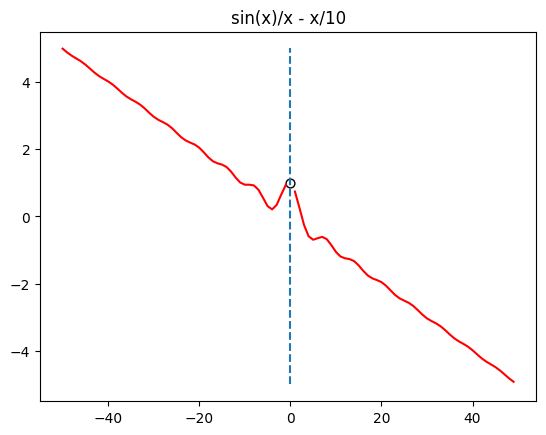

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from torch import arange as trange

x_negative = trange(-50, 0)
x_positive = trange(1, 50)

def y_calc(x):
    return [real_formula(value) for value in x]

y_1 = y_calc(x_negative)
y_2 = y_calc(x_positive)

plt.scatter(0, 1, color='white', marker='o', edgecolors='black', s=40)
plt.plot(x_negative, y_1, c='r')
plt.plot(x_positive, y_2, c='r')
plt.plot(np.zeros(11), np.arange(-5, 6), '--')
plt.title('sin(x)/x - x/10')
plt.show()

#### datasets

In [14]:
batch_size = 200

In [15]:
from torch import FloatTensor, cat

def generate_data(func, n_samples):
    x = FloatTensor(n_samples).uniform_(-1000, 1000)
    x = x[x != 0]

    extra_samples = FloatTensor(n_samples - len(x)).uniform_(-1000000, 1000000)

    x = cat([x, extra_samples])

    y = func(x)[:, None]
    x = x[:, None]

    points = [(x_i, y_i) for x_i, y_i in zip(x, y)]

    return points

real = generate_data(real_formula, 1200)
noise = generate_data(noise_formula, 100)

#### Generator

In [16]:
import torch.nn as nn
from torch import tensor

class Generator(nn.Module):
    def __init__(self, hid_1, in_=1, out_=2):
        super().__init__()
        hid_2 = int(hid_1 * 2)
        hid_4 = int(hid_1 * 4)

        fc1 = nn.Linear(in_, hid_1)
        fc2 = nn.Linear(hid_1, hid_2)
        fc3 = nn.Linear(hid_2, hid_4)
        fc4 = nn.Linear(hid_4, out_)

        relu = nn.ReLU()

        self.model = nn.Sequential(
            fc1, relu,
            fc2, relu,
            fc3, relu,
            fc4
        )

    def forward(self, z):

        point = self.model(z)

        x = point[:, 0].clone().detach()
        y = point[:, 1].clone().detach()

        return x[:, None], y[:, None]

#### Discriminator

In [17]:
class Discriminator(nn.Module):
    def __init__(self, hid_1, in_=1, out_=1):
        super().__init__()
        hid_2 = int(hid_1/2)

        fc1 = nn.Linear(in_, hid_1)
        fc2 = nn.Linear(hid_1, hid_2)
        fc3 = nn.Linear(hid_2, out_)

        l_relu = nn.LeakyReLU(0.2, inplace=True)
        sigmoid = nn.Sigmoid()

        nn.init.uniform_(fc1.weight, -0.005, 0.005)
        fc1.bias.data.zero_()

        self.model = nn.Sequential(
            fc1, l_relu,
            fc2, l_relu,
            fc3, sigmoid
        )

    def forward(self, x):
        batch = x.size(0)
        x = x.view(batch, -1)

        return self.model(x)

#### MyDataset

In [18]:
from torch.utils.data import Dataset, DataLoader

# concatenate data
class MyDataset(Dataset):

    def __init__(self, real, noise):
        self.real = real
        self.noise = noise

    def __getitem__(self, idx):
        if idx < len(self.real):
            return self.real[idx]
        else:
            return self.noise[idx - len(self.real)]

    def __len__(self):
        return len(self.real) + len(self.noise)

dataset = MyDataset(real, noise)
print(dataset[0])

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

(tensor([221.8212]), tensor([-22.1779]))


In [19]:
gen = Generator(hid_1=256)
disc = Discriminator(hid_1=256)

#### Optimizers

In [20]:
from torch.optim import Adam
opt_gen = Adam(gen.parameters(), lr=0.0001)
opt_disc = Adam(disc.parameters(), lr=0.0001)

#### learning

In [21]:
# Оптимизаторы и критерии
from torch import ones_like, zeros_like

criterion = nn.BCELoss()

disc_losses = []
gen_losses = []

epochs = 30

for epoch in range(epochs):
    loss_disc, loss_gen = 0.0, 0.0
    for i, (x_real, y_real) in enumerate(loader):

        # fakes
        x_fake, y_fake = gen(x_real)

        # combine
        x_combined = cat([x_real, x_fake], dim=0)
        y_combined = cat([y_real, y_fake], dim=0)

        disc_out = disc(x_combined)
        loss_disc = criterion(disc_out, ones_like(disc_out))
        disc_losses.append(loss_disc.detach().item())

        loss_disc.backward()
        opt_disc.step()

        # Обучение Генератора
        x_pred, y_pred = gen(x_real)
        disc_fake = disc(cat([x_pred, y_pred], dim=0)).unsqueeze(1)

        loss_gen = criterion(disc_fake, ones_like(disc_fake))

        gen_losses.append(loss_gen.detach().item())
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch {epoch}, Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

Epoch 0, Loss D: 0.5321, Loss G: 0.6724
Epoch 1, Loss D: 0.4561, Loss G: 0.6641
Epoch 2, Loss D: 0.4150, Loss G: 0.6545
Epoch 3, Loss D: 0.4098, Loss G: 0.6466
Epoch 4, Loss D: 0.3699, Loss G: 0.6328
Epoch 5, Loss D: 0.3546, Loss G: 0.6146
Epoch 6, Loss D: 0.3434, Loss G: 0.6003
Epoch 7, Loss D: 0.3344, Loss G: 0.5818
Epoch 8, Loss D: 0.3227, Loss G: 0.5558
Epoch 9, Loss D: 0.3133, Loss G: 0.5313
Epoch 10, Loss D: 0.3066, Loss G: 0.5068
Epoch 11, Loss D: 0.3041, Loss G: 0.4882
Epoch 12, Loss D: 0.2850, Loss G: 0.4454
Epoch 13, Loss D: 0.2864, Loss G: 0.4562
Epoch 14, Loss D: 0.2750, Loss G: 0.4176
Epoch 15, Loss D: 0.2545, Loss G: 0.3737
Epoch 16, Loss D: 0.2502, Loss G: 0.3592
Epoch 17, Loss D: 0.2319, Loss G: 0.3232
Epoch 18, Loss D: 0.2297, Loss G: 0.3060
Epoch 19, Loss D: 0.2131, Loss G: 0.2731
Epoch 20, Loss D: 0.2026, Loss G: 0.2598
Epoch 21, Loss D: 0.1864, Loss G: 0.2453
Epoch 22, Loss D: 0.1696, Loss G: 0.2136
Epoch 23, Loss D: 0.1597, Loss G: 0.1965
Epoch 24, Loss D: 0.1338, 

[0.6290345788002014, 0.6081602573394775, 0.5852939486503601, 0.5690811276435852, 0.553041934967041, 0.5327067375183105, 0.5320953130722046, 0.5112450122833252, 0.5062524080276489, 0.49404415488243103, 0.47715693712234497, 0.4685109853744507, 0.4680088758468628, 0.4560908079147339, 0.453450083732605, 0.44220176339149475, 0.4416641294956207, 0.4301198720932007, 0.42680683732032776, 0.41983017325401306, 0.4150197207927704, 0.4074304699897766, 0.4059654176235199, 0.3890703618526459, 0.4077940881252289, 0.39147987961769104, 0.4019716680049896, 0.40975701808929443, 0.3822069466114044, 0.3796044588088989, 0.3797318935394287, 0.3854389488697052, 0.3752133250236511, 0.3763710856437683, 0.3698614239692688, 0.37562188506126404, 0.36346113681793213, 0.37008586525917053, 0.35711249709129333, 0.3529731035232544, 0.36162030696868896, 0.3546018898487091, 0.3641282320022583, 0.35703644156455994, 0.35072535276412964, 0.34298884868621826, 0.346754789352417, 0.342157781124115, 0.34342655539512634, 0.34225

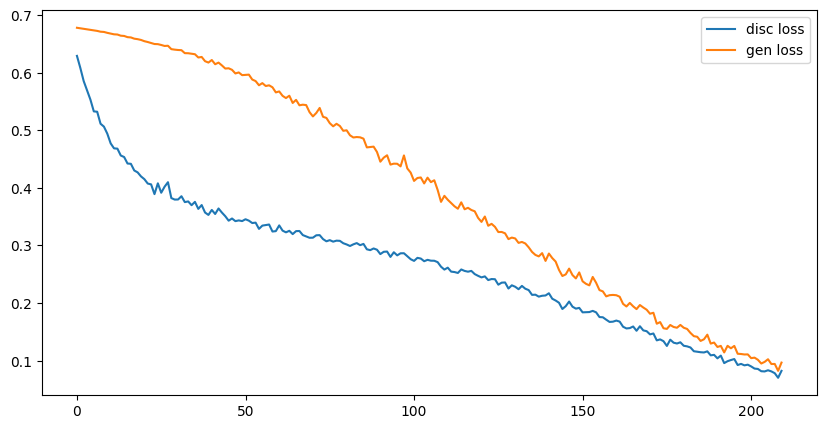

In [22]:
plt.figure(figsize=(10, 5))
print(disc_losses)
plt.plot(range(len(disc_losses)), disc_losses, label='disc loss')
plt.plot(range(len(gen_losses)), gen_losses, label='gen loss')
plt.legend()
plt.show()